# Problem 1 - Numerical part

Let's implement the Gillespie algorithm:

In [111]:
# Import useful packages
import numpy as np # Arrays and stuff
import matplotlib.pyplot as plt # Plotting
from matplotlib import cm
from numba import njit # Pre-compilation for better performance
from scipy.integrate import solve_ivp
from tqdm import tqdm

In [134]:
@njit
def gillespie(T, n0, beta, gamma, delta, n_skip=0):
    # T: timespan to consider
    # n0: initial number of particles
    # beta, gamma, delta: parameters of our reaction
    # n_save: how often to save n value throughout time evolution
    
    t_dat = [0.] # Array to store time values
    n_dat = [n0] # Array to store number of particles
    
    t = 0 # Variable to store time
    n = n0 # Variable to store number of particles
    
    skip_counter = 1 # Start counter to know when to save value
    
    while t < T:
        rp1 = beta*n # Rate of n -> n+1
        rm1 = n*(gamma+delta*(n-1)) # Rate of n -> n-1
        rtot = rm1+rp1 # Total transition rate
        
        wm1 = rm1/rtot # Weight of transition n -> n+1, to sort which will happen
        
        t += np.random.exponential(1/rtot) # Update time according to total transition rate
        
        if np.random.random() < wm1: # Choose transition to happen
            n -= 1 # Annihilate one particle
        else:
            n += 1 # Create a new particle
        
        if n == 0:
            dt = np.percentile(np.diff(np.array(t_dat)), 100)
            while t_dat[-1] < T:
                t_dat.append(t_dat[-1]+dt)
                n_dat.append(0)
            t = T
        
        # If skipped enough iterations, save data
        if skip_counter == n_skip+1:
            t_dat.append(t)
            n_dat.append(n)
            skip_counter = 0
            
        skip_counter += 1 # Count iteration
    
    return np.array(t_dat), np.array(n_dat)

In [135]:
# Mean field approximation ODE
def mean_field(t, n, beta, gamma, delta):
    return (beta-gamma+delta)*n - delta*n**2

# Gaussian approximation ODE
def gauss_approx(t, n, beta, gamma, delta):
    n1, n2 = n
    
    return [(beta-gamma+delta)*n1 - delta*n2,
            (beta+gamma-delta)*n1 + (2*beta - 2*gamma + 3*delta)*n2 + 4*delta*n1**3 - 6*delta*n1*n2]

---

# Simulations

Now that the implementation is settled, let's run a few different simulations. All of our simulations will have $\beta=2$ and $\gamma=1$, and we will test different $\delta$ values: 0.1, 0.01 and 0.001

In [302]:
# Set reaction parameters
beta = 2
gamma = 1

## $\delta$ = 0.001

In [303]:
# Set reaction parameter
delta = 1e-3

# Print indicators associated with mean field and gaussian approximations (refer to hand (and Mathematica) calculations for the derivation of this expressions)
print(f"beta-gamma+delta = {beta-gamma+delta:.5f}")
print(f"(beta-gamma+delta)**2-8*beta*delta = {(beta-gamma+delta)**2-8*beta*delta:.5f}")
print(f"3*beta-3*gamma+4*delta = {3*beta-3*gamma+4*delta:.5f}")
print(f"(3*beta+gamma-2*sqrt(2)*sqrt(beta**2+beta*gamma)) - delta = {(3*beta+gamma-2*np.sqrt(2)*np.sqrt(beta**2+beta*gamma))-delta}")
print(f"delta - (3*beta+gamma+2*sqrt(2)*sqrt(beta**2+beta*gamma)) = {delta-(3*beta+gamma+2*np.sqrt(2)*np.sqrt(beta**2+beta*gamma))}")

beta-gamma+delta = 1.00100
(beta-gamma+delta)**2-8*beta*delta = 0.98600
3*beta-3*gamma+4*delta = 3.00400
(3*beta+gamma-2*sqrt(2)*sqrt(beta**2+beta*gamma)) - delta = 0.07079676972449123
delta - (3*beta+gamma+2*sqrt(2)*sqrt(beta**2+beta*gamma)) = -13.92720323027551


According to the mean-field approximation:
* As $\beta-\gamma+\delta > 0$, we expect a stabilization at $\left\langle n \right\rangle = (\beta-\gamma+\delta)/\delta$.

Now, considering the gaussian approximation:
* $(\beta-\gamma+\delta)^{2}-8\beta\delta > 0$, so $\left\langle n^{2} \right\rangle = \left\langle n \right\rangle = 0$ is unstable, and we have the other two real fixed points: $$\left\langle n \right\rangle_{\pm} = \frac{3(\beta-\gamma+\delta)\pm\sqrt{\left(\beta-\gamma+\delta\right)^{2}-8\beta\delta}}{4\delta}, \; \left\langle n^{2} \right\rangle_{\pm} = \frac{\beta-\gamma+\delta}{\delta}\left\langle n \right\rangle_{\pm}.$$
* We know (thanks to Mathematica) that $\left\langle n \right\rangle_{-}$ won't ever be stable. But, as $\delta < 3\beta+\gamma-2\sqrt{2}\sqrt{\beta^{2}+\beta\gamma}$ (fourth test -- check manuscript), we expect $\left\langle n \right\rangle_{+}$ to be stable.

Let's look at our simulation. To calculate both $\left\langle n(t) \right\rangle$ and $\left\langle n^{2}(t) \right\rangle$, we run 100 simulations and take the averages.

In [304]:
print(f"Stable average expected by MFA: <n> = {(beta-gamma+delta)/delta:.5f}")
print(f"Stable average expected by GA: <n> = {(3*(beta-gamma+delta)++np.sqrt((beta-gamma+delta)**2-8*beta*delta))/(4*delta):.5f}")

Stable average expected by MFA: <n> = 1001.00000
Stable average expected by GA: <n> = 998.99396


100%|██████████| 99/99 [00:02<00:00, 47.65it/s]


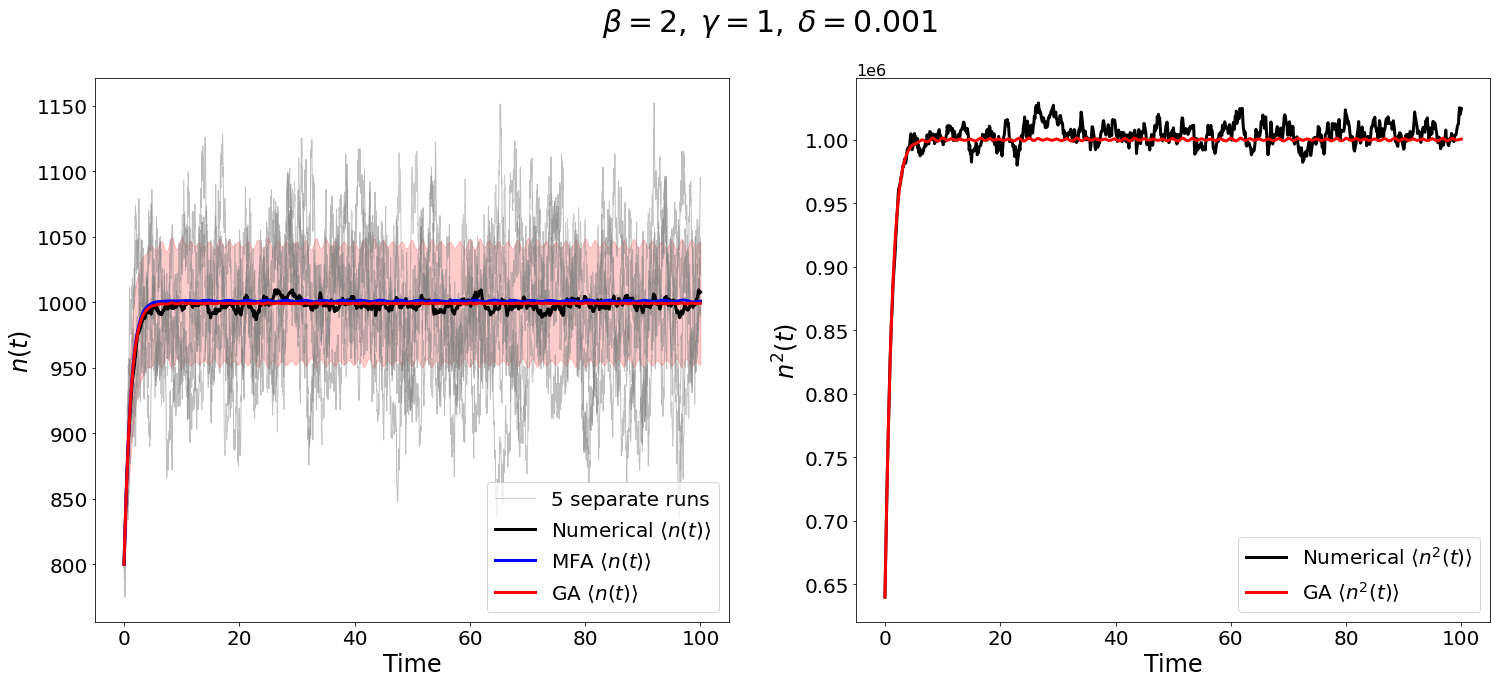

In [305]:
# Time to consider
T = 100

# Starting number of particles, close to expected equilibrium
n0 = 800

t, n = gillespie(T, n0, beta, gamma, delta, 100)

t_ = np.linspace(0, T, 1000)

n_avg = np.interp(t_, t, n)
n2_avg = n_avg**2

# Plots
plt.subplots(1, 2, figsize=(25,10))
plt.subplot(1, 2, 1)

# Loop for multiple executions
for i in tqdm(range(99)):
    t, n = gillespie(T, n0, beta, gamma, delta, 100) # Run simulation
    
    # Plot first 5 executinons
    if i == 0:
        plt.plot(t, n, c="gray", lw=1, label="5 separate runs", alpha=0.4)
    elif i < 5:
        plt.plot(t, n, c="gray", lw=1, alpha=0.5)
    
    # Save interpolation of solution
    n_ = np.interp(t_, t, n)
    
    # Update averages <n> and <n^2>
    n2_avg += (n_**2-n_avg**2)/(i+1)
    n_avg += (n_-n_avg)/(i+1)

n_mf = solve_ivp(mean_field, [t_[0], t_[-1]], [n0], t_eval=t_, args=(beta, gamma, delta)) # MFA solution
n_ga = solve_ivp(gauss_approx, [t_[0], t_[-1]], y0=[n0, n0**2], t_eval=t_, args=(beta, gamma, delta)) # GA solution

n_ga_std = np.sqrt(n_ga.y[1]-n_ga.y[0]**2) # Calculate standard deviation sqrt(<n^2>-<n>^2)


# Plotting
plt.plot(t_, n_avg, c="k", lw=3, label=r"Numerical $\langle n(t) \rangle$")
plt.plot(t_, n_mf.y[0], c="b", lw=3, label=r"MFA $\langle n(t) \rangle$")
plt.plot(t_, n_ga.y[0], c="r", lw=3, label=r"GA $\langle n(t) \rangle$")
plt.fill_between(t_, n_ga.y[0]-n_ga_std, n_ga.y[0]+n_ga_std, color="r", alpha=0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time", fontsize=24)
plt.ylabel("$n(t)$", fontsize=24)
plt.legend(loc="lower right", fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(t_, n2_avg, c="k", lw=3, label=r"Numerical $\langle n^{2}(t) \rangle$")
plt.plot(t_, n_ga.y[1], c="r", lw=3, label=r"GA $\langle n^{2}(t) \rangle$")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time", fontsize=24)
plt.ylabel("$n^{2}(t)$", fontsize=24)
plt.legend(loc="lower right", fontsize=20)
plt.gca().yaxis.offsetText.set_fontsize(16)

plt.suptitle(fr"$\beta={beta},\;\gamma={gamma},\;\delta={delta}$", fontsize=30)
plt.show()

In [306]:
print(f"RMSD between MFA and numerical average: {np.sqrt(np.sum((n_avg-n_mf.y[0])**2)/len(t_)):.5f}")
print(f"RMSD between GA and numerical average: {np.sqrt(np.sum((n_avg-n_ga.y[0])**2)/len(t_)):.5f}")

RMSD between MFA and numerical average: 4.92158
RMSD between GA and numerical average: 4.06825


We see that the results of the MFA approximation matches the numerical $\left\langle n(t) \right\rangle$ well, but the GA approximation has an even better agreement, and also provides a good estimation for the numerical $\left\langle n(t) \right\rangle$ and $\left\langle n^{2}(t) \right\rangle$.

## $\delta$ = 0.01

In [307]:
# Set reaction parameter
delta = 1e-2

# Print indicators associated with mean field and gaussian approximations (refer to hand (and Mathematica) calculations for the derivation of this expressions)
print(f"beta-gamma+delta = {beta-gamma+delta:.5f}")
print(f"(beta-gamma+delta)**2-8*beta*delta = {(beta-gamma+delta)**2-8*beta*delta:.5f}")
print(f"3*beta-3*gamma+4*delta = {3*beta-3*gamma+4*delta:.5f}")
print(f"(3*beta+gamma-2*sqrt(2)*sqrt(beta**2+beta*gamma)) - delta = {(3*beta+gamma-2*np.sqrt(2)*np.sqrt(beta**2+beta*gamma))-delta}")
print(f"delta - (3*beta+gamma+2*sqrt(2)*sqrt(beta**2+beta*gamma)) = {delta-(3*beta+gamma+2*np.sqrt(2)*np.sqrt(beta**2+beta*gamma))}")

beta-gamma+delta = 1.01000
(beta-gamma+delta)**2-8*beta*delta = 0.86010
3*beta-3*gamma+4*delta = 3.04000
(3*beta+gamma-2*sqrt(2)*sqrt(beta**2+beta*gamma)) - delta = 0.061796769724491225
delta - (3*beta+gamma+2*sqrt(2)*sqrt(beta**2+beta*gamma)) = -13.918203230275509


Again, we have the same expectations from each approximation for the stable fixed points:

According to the mean-field approximation:
$$\left\langle n \right\rangle = (\beta-\gamma+\delta)/\delta.$$

For the gaussian approximation:
$$\left\langle n \right\rangle = \frac{3(\beta-\gamma+\delta)\pm\sqrt{\left(\beta-\gamma+\delta\right)^{2}-8\beta\delta}}{4\delta}, \; \left\langle n^{2} \right\rangle = \frac{\beta-\gamma+\delta}{\delta}\left\langle n \right\rangle_{\pm}.$$

Let's look at the simulations!

In [308]:
print(f"Stable average expected by MFA: <n> = {(beta-gamma+delta)/delta:.5f}")
print(f"Stable average expected by GA: <n> = {(3*(beta-gamma+delta)++np.sqrt((beta-gamma+delta)**2-8*beta*delta))/(4*delta):.5f}")

Stable average expected by MFA: <n> = 101.00000
Stable average expected by GA: <n> = 98.93539


100%|██████████| 99/99 [00:00<00:00, 424.88it/s]


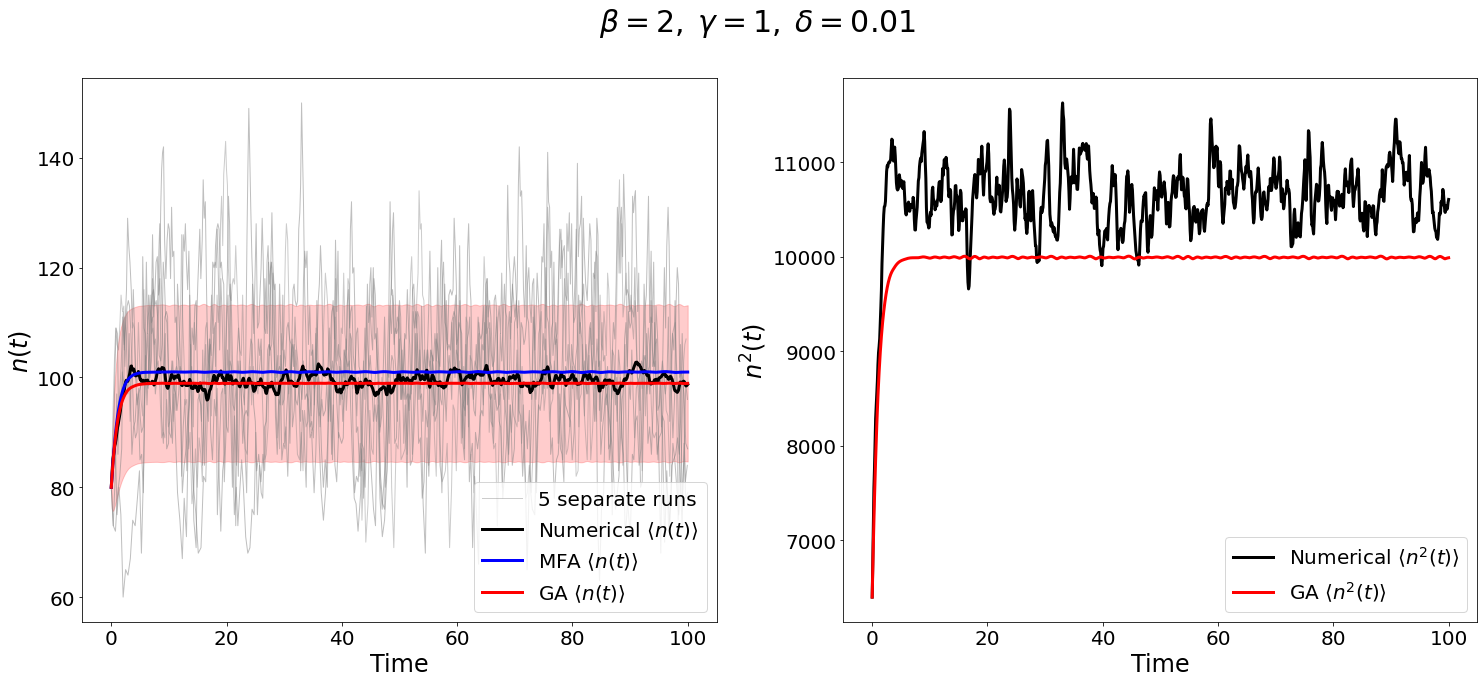

In [310]:
# Time to consider
T = 100

# Starting number of particles, close to expected equilibrium
n0 = 80

t, n = gillespie(T, n0, beta, gamma, delta, 100)

t_ = np.linspace(0, T, 1000)

n_avg = np.interp(t_, t, n)
n2_avg = n_avg**2

# Plots
plt.subplots(1, 2, figsize=(25,10))
plt.subplot(1, 2, 1)

# Loop for multiple executions
for i in tqdm(range(99)):
    t, n = gillespie(T, n0, beta, gamma, delta, 100) # Run simulation
    
    # Plot first 5 executinons
    if i == 0:
        plt.plot(t, n, c="gray", lw=1, label="5 separate runs", alpha=0.4)
    elif i < 5:
        plt.plot(t, n, c="gray", lw=1, alpha=0.5)
    
    # Save interpolation of solution
    n_ = np.interp(t_, t, n)
    
    # Update averages <n> and <n^2>
    n2_avg += (n_**2-n_avg**2)/(i+1)
    n_avg += (n_-n_avg)/(i+1)

n_mf = solve_ivp(mean_field, [t_[0], t_[-1]], [n0], t_eval=t_, args=(beta, gamma, delta)) # MFA solution
n_ga = solve_ivp(gauss_approx, [t_[0], t_[-1]], y0=[n0, n0**2], t_eval=t_, args=(beta, gamma, delta)) # GA solution

n_ga_std = np.sqrt(n_ga.y[1]-n_ga.y[0]**2) # Calculate standard deviation sqrt(<n^2>-<n>^2)


# Plotting
plt.plot(t_, n_avg, c="k", lw=3, label=r"Numerical $\langle n(t) \rangle$")
plt.plot(t_, n_mf.y[0], c="b", lw=3, label=r"MFA $\langle n(t) \rangle$")
plt.plot(t_, n_ga.y[0], c="r", lw=3, label=r"GA $\langle n(t) \rangle$")
plt.fill_between(t_, n_ga.y[0]-n_ga_std, n_ga.y[0]+n_ga_std, color="r", alpha=0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time", fontsize=24)
plt.ylabel("$n(t)$", fontsize=24)
plt.legend(loc="lower right", fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(t_, n2_avg, c="k", lw=3, label=r"Numerical $\langle n^{2}(t) \rangle$")
plt.plot(t_, n_ga.y[1], c="r", lw=3, label=r"GA $\langle n^{2}(t) \rangle$")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time", fontsize=24)
plt.ylabel("$n^{2}(t)$", fontsize=24)
plt.legend(loc="lower right", fontsize=20)
plt.gca().yaxis.offsetText.set_fontsize(16)

plt.suptitle(fr"$\beta={beta},\;\gamma={gamma},\;\delta={delta}$", fontsize=30)
plt.show()

In [311]:
print(f"RMSD between MFA and numerical average: {np.sqrt(np.sum((n_avg-n_mf.y[0])**2)/len(t_)):.5f}")
print(f"RMSD between GA and numerical average: {np.sqrt(np.sum((n_avg-n_ga.y[0])**2)/len(t_)):.5f}")

RMSD between MFA and numerical average: 1.91825
RMSD between GA and numerical average: 1.32963


Looking at $\left\langle n(t) \right\rangle$, we have again better results from the GA approximation. Despite that, the approximative prediction for $\left\langle n^{2}(t) \right\rangle$ is not that good.

## $\delta$ = 0.1

In [319]:
# Set reaction parameter
delta = 1e-1

# Print indicators associated with mean field and gaussian approximations (refer to hand (and Mathematica) calculations for the derivation of this expressions)
print(f"beta-gamma+delta = {beta-gamma+delta:.5f}")
print(f"(beta-gamma+delta)**2-8*beta*delta = {(beta-gamma+delta)**2-8*beta*delta:.5f}")
print(f"3*beta-3*gamma+4*delta = {3*beta-3*gamma+4*delta:.5f}")
print(f"(3*beta+gamma-2*sqrt(2)*sqrt(beta**2+beta*gamma)) - delta = {(3*beta+gamma-2*np.sqrt(2)*np.sqrt(beta**2+beta*gamma))-delta}")
print(f"delta - (3*beta+gamma+2*sqrt(2)*sqrt(beta**2+beta*gamma)) = {delta-(3*beta+gamma+2*np.sqrt(2)*np.sqrt(beta**2+beta*gamma))}")

beta-gamma+delta = 1.10000
(beta-gamma+delta)**2-8*beta*delta = -0.39000
3*beta-3*gamma+4*delta = 3.40000
(3*beta+gamma-2*sqrt(2)*sqrt(beta**2+beta*gamma)) - delta = -0.028203230275508778
delta - (3*beta+gamma+2*sqrt(2)*sqrt(beta**2+beta*gamma)) = -13.82820323027551


According to the mean-field approximation:
* As $\beta-\gamma+\delta > 0$, we expect a stabilization at $\left\langle n \right\rangle = (\beta-\gamma+\delta)/\delta$.

Now, considering the gaussian approximation:
* $(\beta-\gamma+\delta)^{2}-8\beta\delta < 0$, so $\left\langle n^{2} \right\rangle = \left\langle n \right\rangle = 0$ is the only possible fixed point. But $3\beta-3\gamma+4\delta > 0$ so this point is unstable. Considering this, we could expect the solution to diverge, as the solution will be repelled by the trivial fixed point, but there is no other point where the solution can take a null value, so it will grow monotonically.

Having this in mind, we will consider only the MFA in this case:

In [320]:
print(f"Stable average expected by MFA: <n> = {(beta-gamma+delta)/delta:.5f}")
# print(f"Stable average expected by GA: <n> = {(3*(beta-gamma+delta)++np.sqrt((beta-gamma+delta)**2-8*beta*delta))/(4*delta):.5f}")

Stable average expected by MFA: <n> = 11.00000


100%|██████████| 99/99 [00:00<00:00, 2583.95it/s]


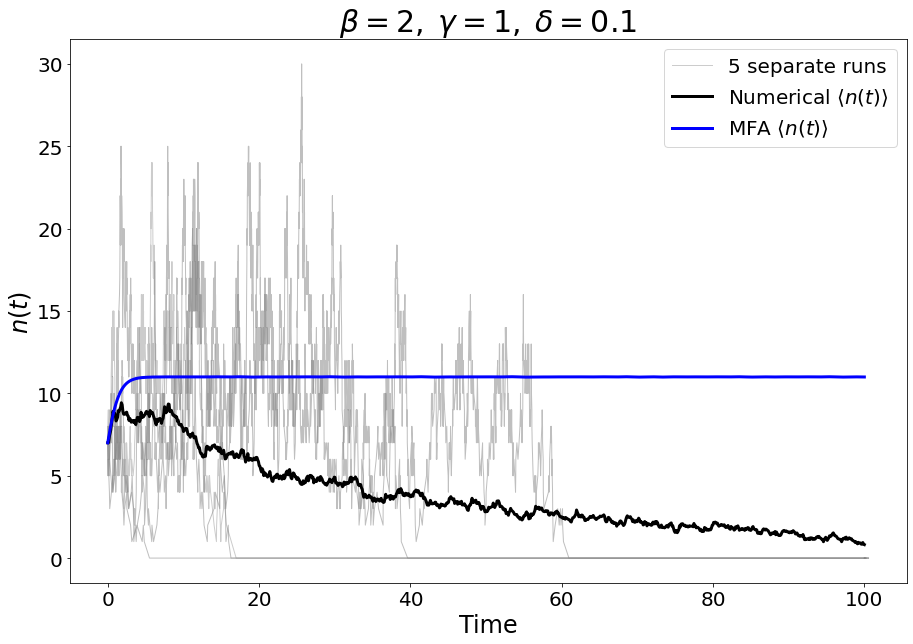

In [328]:
# Time to consider
T = 100

# Starting number of particles, close to expected equilibrium
n0 = 7

t, n = gillespie(T, n0, beta, gamma, delta, 100)

t_ = np.linspace(0, T, 1000)

n_avg = np.interp(t_, t, n)
n2_avg = n_avg**2

# Plots
plt.figure(figsize=(15,10))
# plt.subplots(1, 2, figsize=(25,10))
# plt.subplot(1, 2, 1)

# Loop for multiple executions
for i in tqdm(range(99)):
    t, n = gillespie(T, n0, beta, gamma, delta) # Run simulation
    
    # Plot first 5 executinons
    if i == 0:
        plt.plot(t, n, c="gray", lw=1, label="5 separate runs", alpha=0.4)
    elif i < 5:
        plt.plot(t, n, c="gray", lw=1, alpha=0.5)
    
    # Save interpolation of solution
    n_ = np.interp(t_, t, n)
    
    # Update averages <n> and <n^2>
    n2_avg += (n_**2-n_avg**2)/(i+1)
    n_avg += (n_-n_avg)/(i+1)

n_mf = solve_ivp(mean_field, [t_[0], t_[-1]], [n0], t_eval=t_, args=(beta, gamma, delta)) # MFA solution
# n_ga = solve_ivp(gauss_approx, [t_[0], t_[-1]], y0=[n0, n0**2], t_eval=t_, args=(beta, gamma, delta)) # GA solution

# n_ga_std = np.sqrt(n_ga.y[1]-n_ga.y[0]**2) # Calculate standard deviation sqrt(<n^2>-<n>^2)

# Plotting
plt.plot(t_, n_avg, c="k", lw=3, label=r"Numerical $\langle n(t) \rangle$")
plt.plot(t_, n_mf.y[0], c="b", lw=3, label=r"MFA $\langle n(t) \rangle$")
# plt.plot(t_, n_ga.y[0], c="r", lw=3, label=r"GA $\langle n(t) \rangle$")
# plt.fill_between(t_, n_ga.y[0]-n_ga_std, n_ga.y[0]+n_ga_std, color="r", alpha=0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time", fontsize=24)
plt.ylabel("$n(t)$", fontsize=24)
plt.legend(loc="upper right", fontsize=20)

# plt.subplot(1, 2, 2)
# plt.plot(t_, n2_avg, c="k", lw=3, label=r"Numerical $\langle n^{2}(t) \rangle$")
# plt.plot(t_, n_ga.y[1], c="r", lw=3, label=r"GA $\langle n^{2}(t) \rangle$")
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.xlabel("Time", fontsize=24)
# plt.ylabel("$n^{2}(t)$", fontsize=24)
# plt.legend(loc="lower right", fontsize=20)
# plt.gca().yaxis.offsetText.set_fontsize(16)

plt.title(fr"$\beta={beta},\;\gamma={gamma},\;\delta={delta}$", fontsize=30)
# plt.suptitle(fr"$\beta={beta},\;\gamma={gamma},\;\delta={delta}$", fontsize=30)
plt.show()

In [329]:
print(f"RMSD between MFA and numerical average: {np.sqrt(np.sum((n_avg-n_mf.y[0])**2)/len(t_)):.5f}")
# print(f"RMSD between GA and numerical average: {np.sqrt(np.sum((n_avg-n_ga.y[0])**2)/len(t_)):.5f}")

RMSD between MFA and numerical average: 7.57113


One can see that, comparing to the numerical result, the MFA starts very well, but the error grows with time. This happens because of the executions in which $n$ becomes zero, and can never grow again, as $n=0$ is an absorbing state. Let's try to compare the MFA with the average only over executions such that $n$ doesn't become zero in the considered time.

100%|██████████| 99/99 [00:00<00:00, 679.51it/s]


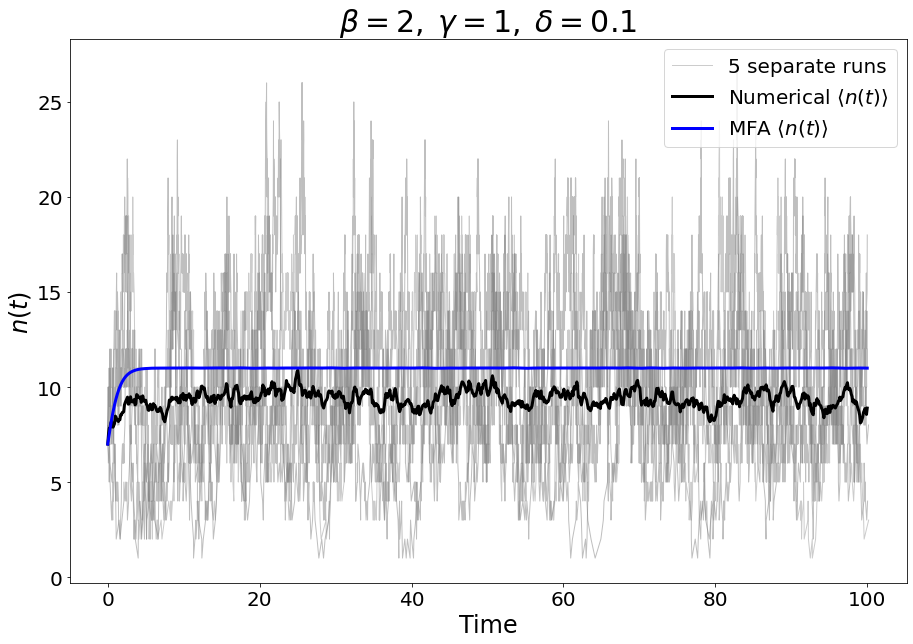

In [330]:
# Time to consider
T = 100

# Starting number of particles, close to expected equilibrium
n0 = 7

n = [0]
while n[-1] == 0:
    t, n = gillespie(T, n0, beta, gamma, delta)

t_ = np.linspace(0, T, 1000)

n_avg = np.interp(t_, t, n)
n2_avg = n_avg**2

plt.figure(figsize=(15,10))

for i in tqdm(range(99)):
    n = [0]
    while n[-1] == 0:
        t, n = gillespie(T, n0, beta, gamma, delta)
    if i == 0:
        plt.plot(t, n, c="gray", lw=1, label="5 separate runs", alpha=0.4)
    
    elif i < 5:
        plt.plot(t, n, c="gray", lw=1, alpha=0.5)
    
    n_ = np.interp(t_, t, n)
    n2_avg += (n_**2-n_avg**2)/(i+1)
    n_avg += (n_-n_avg)/(i+1)

n_mf = solve_ivp(mean_field, [t_[0], t_[-1]], [n0], t_eval=t_, args=(beta, gamma, delta))

plt.plot(t_, n_avg, c="k", lw=3, label=r"Numerical $\langle n(t) \rangle$")
plt.plot(t_, n_mf.y[0], c="b", lw=3, label=r"MFA $\langle n(t) \rangle$")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time", fontsize=24)
plt.ylabel("$n(t)$", fontsize=24)
plt.legend(loc="upper right", fontsize=20)

plt.title(fr"$\beta={beta},\;\gamma={gamma},\;\delta={delta}$", fontsize=30)
plt.show()

We see now that the results are much better. This can be understood by the fact that we don't input the fact that $n=0$ is an absorbing state when we do the mean field approximation.